## Texas State COVID Response Analysis
This notebook contains the work to identify associations between the Texas state governmental response and the COVID-19 case count throughout the pandemic.


## Data Cleanup
As with most data mining projects, we will need to clean up the given data file in order to focus on the goal at hand. The "all-states-history.csv" file is a dataset of U.S. COVID-19 cases and deaths dating from the start of the pandemic to 11/29/20 and was sourced from [The Covid Tracking Project](https://covidtracking.com/data). 

In order to analyze with state policy actions, we will merge data from the [Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker) github dataset titled 'state-policies.csv'. Then we can encode  the data for market basket analysis.  

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

Need to a way to discretize and format data too be suitable for apriori analysis. The function below will discretize the necessary columns into bins and set the values to strings according to the bin they are placed in.  

In [2]:
def discretize_data2(arr, k):
    cols = arr.columns
    for i in cols:
        bin_range = pd.cut(arr[i],k)
        col_copy = arr[i].astype('str')
        for j in range(len(col_copy)):
            col_copy[j] = i + "" +str(bin_range[j])
            
        arr[i] = col_copy   

Initializing the dataframes

In [3]:
# COVID tracking project data
covid_data = pd.read_csv('all-states-history.csv')

# state plicy data
policy_data = pd.read_csv('state-policies.csv')

C:\Users\Sam\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Cleaning up Covid data to only include Minnesota instances and the appropriate attributes

In [4]:
#isolating the columns we need
columns_to_show = ['date','state','death','deathConfirmed','deathIncrease','hospitalized','hospitalizedIncrease','negative'
                   ,'negativeIncrease','positive','positiveIncrease','totalTestResults','totalTestResultsIncrease']

#isolating only for MN data and putting in order March->November
covid_clean_data = covid_data[covid_data['state'] == 'TX']
covid_clean_data = covid_clean_data[columns_to_show]
covid_clean_data = covid_clean_data.iloc[::-1]

#reindexing for weekly processing 
covid_clean_data['date'] = covid_clean_data['date'].astype('datetime64[ns]')
covid_clean_data = covid_clean_data.set_index('date')

# isolating the columns that need to be summed when converting to weekly index
increase_cols = covid_clean_data[['deathIncrease','hospitalizedIncrease','negativeIncrease','positiveIncrease','totalTestResultsIncrease']]
increase_cols = increase_cols.reset_index(drop = True)
preProcess_covid = increase_cols.copy()

discretize_data2(increase_cols,6)
covid_clean_data = covid_clean_data.reset_index()
preProcess_covid.head()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,4,4
3,0,0,0,3,3
4,0,0,0,0,0


Cleaning up state policy dataframe:

In [10]:
#isolating data only about the current state of interest, Minnesota
policy_clean_data = policy_data[policy_data['RegionName'] == 'Texas']

#declaring and extracting columns of interest from the original dataset
columns_of_interest = ['Date', 'C1_School closing', 'C2_Workplace closing', 
                       'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C6_Stay at home requirements', 
                       'C7_Restrictions on internal movement', 'C8_International travel controls', 
                       'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 
                       'H4_Emergency investment in healthcare', 
                       'H6_Facial Coverings']
policy_clean_data = policy_clean_data[columns_of_interest].fillna(0)

# reformating date section and range of dates needed
policy_clean_data = policy_clean_data.reset_index(drop = True)
from datetime import datetime as dt

date_col = policy_clean_data['Date'].astype('str')
for i in range(policy_clean_data.shape[0]):
    date_col[i] = dt.strptime(date_col[i], "%Y%m%d")
    
policy_clean_data['Date'] = date_col

start_date = covid_clean_data['date'][0]
end_date = covid_clean_data['date'][covid_clean_data.shape[0]-1]

policy_clean_data = policy_clean_data.rename(columns = {"Date": "date"})

policy_clean_data = policy_clean_data.set_index('date')

policy_clean_data = policy_clean_data[start_date:end_date].reset_index(drop=True)

preProcess_policy = policy_clean_data.copy()

policy_clean_data.head()

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H6_Facial Coverings
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [11]:
merge_before_transform = pd.merge(preProcess_covid, preProcess_policy, left_index = True, right_index = True)
merge_before_transform.head()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H6_Facial Coverings
0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0,0,0,4,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0,0,0,3,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


Changing values of policy_clean_data to the type of policy each number corresponds to:

In [12]:
#C1_School closing
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(0, 'no measures, school closing')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(1, 'recommend closing or all schools open with alterations')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(2, 'require closing only some levels or categories')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(3, 'require closing all levels, school closing')
#C2_Workplace closing
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(0, 'no measures, workplace closing')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(1, 'recommend closing (or recommend work from home)')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(2, 'require closing (or work from home) for some sectors or categories of workers')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(3, 'require closing (or work from home) for all-but-essential workplaces (eg grocery stores, doctors)')
#C3_Cancel public events
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(0, 'no measures, cancel public events')
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(1, 'recommend cancelling public events')
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(2, 'require cancelling public events')
#C4_Restrictions on gatherings                                                                                            
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(0, 'no restrictions on gatherings')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(1, 'restrictions on very large gatherings (the limit is above 1000 people)')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(2, 'restrictions on gatherings between 101-1000 people')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(3, 'restrictions on gatherings between 11-100 people')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(4, 'restrictions on gatherings of 10 people or less')
#C6_Stay at home requirements                                                                                            
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(0, 'no measures for stay at home requirement')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(1, 'recommend not leaving house')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(2, 'require not leaving house with exceptions for "essential" activities')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(3, 'require not leaving house with minimal exceptions')
#C7_Restrictions on internal movement
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(0, 'no measures on restrictions on internal movement')
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(1, 'recommend not to travel between regions/cities')
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(2, 'internal movement restrictions in place')
#C8_International travel controls
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(0, 'no restrictions on international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(1, 'screening arrivals on international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(2, 'quarantine arrivals from some or all regions for international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(3, 'ban arrivals from some regions for international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(4, 'ban on all regions or total border closure')
#H1_Public information campaigns
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(0, 'no Covid-19 public information campaign')
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(1, 'public officials urging caution about Covid-19')
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(2, 'coordinated public information campaign ')
#H2_Testing policy
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(0, 'no testing policy')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(1, 'only those who both (a) have symptoms AND (b) meet specific criteria')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(2, 'testing of anyone showing Covid-19 symptoms')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(3, 'open public testing')
#H3_Contact tracing
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(0, 'no contact tracing')
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(1, 'limited contact tracing; not done for all cases')
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(2, 'comprehensive contact tracing; done for all identified cases')
#H4_Emergency investment in healthcare
### not a code, simply records the monetary value in USD
policy_clean_data['H4_Emergency investment in healthcare'] = policy_clean_data['H4_Emergency investment in healthcare'].mask(policy_clean_data['H4_Emergency investment in healthcare'] > 0, 'investment')
policy_clean_data['H4_Emergency investment in healthcare'] = policy_clean_data['H4_Emergency investment in healthcare'].replace(0, 'no new spending that day')

#H6_Facial Coverings
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(0, 'no policy on facial coverings')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(1, 'recommended facial coverings')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(2, 'facial coverings required in some specified shared/public spaces')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(3, 'facial coverings required in all shared/public spaces')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(4, 'facial coverings required outside the home at all times')
                                                                                              

In [14]:
policy_clean_data.head()

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H6_Facial Coverings
0,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
1,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
2,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
3,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
4,"no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings


Merging dataframes to create the basket:

In [13]:
TX_basket = pd.merge(increase_cols, policy_clean_data, left_index=True, right_index=True)
TX_basket.head()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H6_Facial Coverings
0,"deathIncrease(-0.675, 112.5]","hospitalizedIncrease(-0.000333, 0.0]","negativeIncrease(-13476.333, 68380.333]","positiveIncrease(-17.82, 2970.0]","totalTestResultsIncrease(-9065.333, 72891.333]","no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
1,"deathIncrease(-0.675, 112.5]","hospitalizedIncrease(-0.000333, 0.0]","negativeIncrease(-13476.333, 68380.333]","positiveIncrease(-17.82, 2970.0]","totalTestResultsIncrease(-9065.333, 72891.333]","no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
2,"deathIncrease(-0.675, 112.5]","hospitalizedIncrease(-0.000333, 0.0]","negativeIncrease(-13476.333, 68380.333]","positiveIncrease(-17.82, 2970.0]","totalTestResultsIncrease(-9065.333, 72891.333]","no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
3,"deathIncrease(-0.675, 112.5]","hospitalizedIncrease(-0.000333, 0.0]","negativeIncrease(-13476.333, 68380.333]","positiveIncrease(-17.82, 2970.0]","totalTestResultsIncrease(-9065.333, 72891.333]","no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings
4,"deathIncrease(-0.675, 112.5]","hospitalizedIncrease(-0.000333, 0.0]","negativeIncrease(-13476.333, 68380.333]","positiveIncrease(-17.82, 2970.0]","totalTestResultsIncrease(-9065.333, 72891.333]","no measures, school closing","no measures, workplace closing","no measures, cancel public events",no restrictions on gatherings,no measures for stay at home requirement,no measures on restrictions on internal movement,screening arrivals on international travel,no Covid-19 public information campaign,only those who both (a) have symptoms AND (b) ...,limited contact tracing; not done for all cases,no new spending that day,no policy on facial coverings


## Analysis

Important TX Stats:

- Population (mn.gov estimate): 28,995,881
- Land Area (estimate): 261,231.71 sq. mi.
- Population Density: 96.3 people/sq. mi.

Before we jump into Apriori, it would be nice to get a vizual of the basket data, we will create a tree map similar to the one in Project 2's "apriori analysis" notebook: 

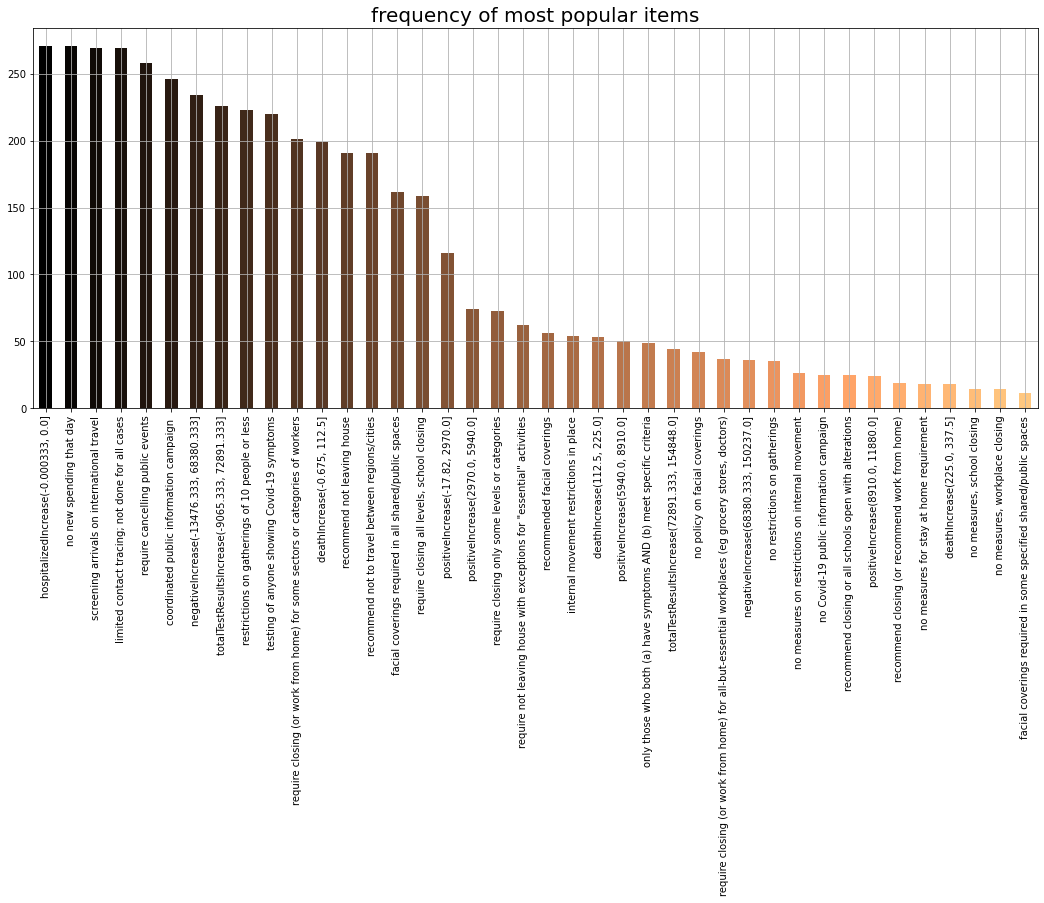

In [14]:
from wordcloud import WordCloud

all_elements = TX_basket.values.tolist()
flat_list = [item for sublist in all_elements for item in sublist]
temp_df = pd.DataFrame({'col':flat_list})


plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
temp_df['col'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

As we can see, the most frequent items are:

- hospitalized increase (-.0005, 0]
- no new spendig that day
- screening arrivals on international travels

This doesn't provide too much information for how mandates relate to trends in cases, so lets do some association mining.

Now that we have the data set up as a series of 'transactions' with items (basket), we just need to encode the items and then use Apriori analysis and find association rules:

In [9]:
basket_array = TX_basket.values
basket_cols = TX_basket.columns
te = TransactionEncoder()
te_dataset = te.fit(basket_array).transform(basket_array)

TX_te_basket = pd.DataFrame(te_dataset, columns = te.columns_)
te.columns_

['coordinated public information campaign (eg across traditional and social media)',
 'deathIncrease(-0.675, 168.75]',
 'deathIncrease(168.75, 337.5]',
 'deathIncrease(506.25, 675.0]',
 'facial coverings required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible',
 'facial coverings required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible',
 'hospitalizedIncrease(-0.0005, 0.0]',
 'internal movement restrictions in place',
 'limited contact tracing; not done for all cases',
 'negativeIncrease(-341394.14, -218118.0]',
 'negativeIncrease(-95333.0, 27452.0]',
 'negativeIncrease(27452.0, 150237.0]',
 'no Covid-19 public information campaign',
 'no contact tracing',
 'no measures for stay at home requirement',
 'no measures on restrictions on internal movement',
 'no measures, cancel public events',
 'no measures, school closing'

In [10]:
TX_freq_itemsets = apriori(TX_te_basket, min_support=0.4, use_colnames=True)

In [11]:
TX_freq_itemsets['length'] = TX_freq_itemsets['itemsets'].apply(lambda x: len(x))

In [46]:
rules = association_rules(TX_freq_itemsets, metric="support", min_threshold=0.2)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequent_len"] = rules["consequents"].apply(lambda x: len(x))
len(rules)

2608404

Now we can mine for associations:

In [48]:
len6 = rules[rules['antecedent_len'] >= 6]

len(len6)

569222

In [63]:
contact_tracing = rules[(rules['antecedents'] == {'limited contact tracing; not done for all cases'})
                    & (rules['antecedent support'] >= 0.9) 
                    & (rules['confidence'] >= 0.9)]
contact_tracing.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
6,(limited contact tracing; not done for all cases),(coordinated public information campaign (eg a...,0.99262,0.907749,0.907749,0.914498,1.007435,0.006699,1.078935,1,1
90,(limited contact tracing; not done for all cases),"(hospitalizedIncrease(-0.0005, 0.0])",0.99262,1.000000,0.992620,1.000000,1.000000,0.000000,inf,1,1
124,(limited contact tracing; not done for all cases),(no new spending that day),0.99262,1.000000,0.992620,1.000000,1.000000,0.000000,inf,1,1
132,(limited contact tracing; not done for all cases),(require cancelling public events),0.99262,0.952030,0.952030,0.959108,1.007435,0.007026,1.173096,1,1
140,(limited contact tracing; not done for all cases),(screening arrivals on international travel),0.99262,0.992620,0.992620,1.000000,1.007435,0.007326,inf,1,1


In [83]:
school_restrictions = rules[(rules['consequents'] == {'positiveIncrease(-17.82, 4455.0]'})
                           &(rules['support'] >=0.5) ].reset_index(drop=True)
school_restrictions.head(60)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,"(deathIncrease(-0.675, 168.75])","(positiveIncrease(-17.82, 4455.0])",0.859779,0.586716,0.571956,0.665236,1.133830,0.067510,1.234554,1,1
1,"(hospitalizedIncrease(-0.0005, 0.0])","(positiveIncrease(-17.82, 4455.0])",1.000000,0.586716,0.586716,0.586716,1.000000,0.000000,1.000000,1,1
2,(limited contact tracing; not done for all cases),"(positiveIncrease(-17.82, 4455.0])",0.992620,0.586716,0.583026,0.587361,1.001099,0.000640,1.001562,1,1
3,(no new spending that day),"(positiveIncrease(-17.82, 4455.0])",1.000000,0.586716,0.586716,0.586716,1.000000,0.000000,1.000000,1,1
4,(require cancelling public events),"(positiveIncrease(-17.82, 4455.0])",0.952030,0.586716,0.542435,0.569767,0.971113,-0.016135,0.960606,1,1
5,(screening arrivals on international travel),"(positiveIncrease(-17.82, 4455.0])",0.992620,0.586716,0.583026,0.587361,1.001099,0.000640,1.001562,1,1
6,"(hospitalizedIncrease(-0.0005, 0.0], deathIncr...","(positiveIncrease(-17.82, 4455.0])",0.859779,0.586716,0.571956,0.665236,1.133830,0.067510,1.234554,2,1
7,(limited contact tracing; not done for all cas...,"(positiveIncrease(-17.82, 4455.0])",0.852399,0.586716,0.568266,0.666667,1.136268,0.068150,1.239852,2,1
8,"(no new spending that day, deathIncrease(-0.67...","(positiveIncrease(-17.82, 4455.0])",0.859779,0.586716,0.571956,0.665236,1.133830,0.067510,1.234554,2,1
9,"(require cancelling public events, deathIncrea...","(positiveIncrease(-17.82, 4455.0])",0.811808,0.586716,0.527675,0.650000,1.107862,0.051375,1.180812,2,1


In [55]:
school_restrictions['antecedents'][2]

frozenset({'deathIncrease(-0.675, 168.75]',
           'negativeIncrease(-95333.0, 27452.0]'})

In [46]:
work_restrictions = rules[(rules['antecedents'] == {'recommend closing (or recommend work from home)'})
                    & (rules['antecedent support'] >= 0.7) 
                    & (rules['confidence'] >= 0.7)]
work_restrictions.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len


In [15]:
public_events = rules[(rules['antecedents'] == {'no measures for stay at home requirement'})
                    & (rules['antecedent support'] >= 0.7) 
                    & (rules['confidence'] >= 0.7)]
public_events.head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len


In [69]:
gathering_restrictions = rules[(rules['antecedents'] == {'restrictions on gatherings between 11-100 people'})
                    & (rules['antecedent support'] >= 0.5)]
gathering_restrictions.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len


In [29]:
len3 = rules[rules['ant']]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(coordinated public information campaign (eg a...,"(deathIncrease(-0.675, 168.75])",0.907749,0.859779,0.767528,0.845528,0.983426,-0.012936,0.907749,1
32,(facial coverings required in all shared/publi...,"(deathIncrease(-0.675, 168.75])",0.597786,0.859779,0.457565,0.765432,0.890267,-0.056399,0.597786,1
34,"(hospitalizedIncrease(-0.0005, 0.0])","(deathIncrease(-0.675, 168.75])",1.000000,0.859779,0.859779,0.859779,1.000000,0.000000,1.000000,1
36,(limited contact tracing; not done for all cases),"(deathIncrease(-0.675, 168.75])",0.992620,0.859779,0.852399,0.858736,0.998787,-0.001035,0.992620,1
38,"(negativeIncrease(-95333.0, 27452.0])","(deathIncrease(-0.675, 168.75])",0.457565,0.859779,0.428044,0.935484,1.088052,0.034640,2.173432,1
40,"(negativeIncrease(27452.0, 150237.0])","(deathIncrease(-0.675, 168.75])",0.538745,0.859779,0.428044,0.794521,0.924099,-0.035157,0.682411,1
42,(no new spending that day),"(deathIncrease(-0.675, 168.75])",1.000000,0.859779,0.859779,0.859779,1.000000,0.000000,1.000000,1
44,"(positiveIncrease(-17.82, 4455.0])","(deathIncrease(-0.675, 168.75])",0.586716,0.859779,0.571956,0.974843,1.133830,0.067510,5.573801,1
47,(recommend not leaving house),"(deathIncrease(-0.675, 168.75])",0.704797,0.859779,0.564576,0.801047,0.931690,-0.041394,0.704797,1
48,(recommend not to travel between regions/cities),"(deathIncrease(-0.675, 168.75])",0.704797,0.859779,0.564576,0.801047,0.931690,-0.041394,0.704797,1


In [59]:
len4_conseq = rules[(rules['consequent_len'] >= 4) 
                   & (rules['support'] > 0.7)
                   & (rules['confidence'] >= 0.8)].reset_index(drop=True)
len4_conseq.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,"(deathIncrease(-0.675, 168.75])",(limited contact tracing; not done for all cas...,0.859779,0.907749,0.767528,0.892704,0.983426,-0.012936,0.859779,1,4
1,(coordinated public information campaign (eg a...,(limited contact tracing; not done for all cas...,0.907749,0.852399,0.767528,0.845528,0.991940,-0.006236,0.955525,1,4
2,"(deathIncrease(-0.675, 168.75])",(limited contact tracing; not done for all cas...,0.859779,0.892989,0.752768,0.875536,0.980456,-0.015005,0.859779,1,4
3,(coordinated public information campaign (eg a...,(limited contact tracing; not done for all cas...,0.907749,0.811808,0.752768,0.829268,1.021508,0.015849,1.102267,1,4
4,"(deathIncrease(-0.675, 168.75])",(limited contact tracing; not done for all cas...,0.859779,0.907749,0.767528,0.892704,0.983426,-0.012936,0.859779,1,4
5,(coordinated public information campaign (eg a...,(limited contact tracing; not done for all cas...,0.907749,0.852399,0.767528,0.845528,0.991940,-0.006236,0.955525,1,4
6,"(deathIncrease(-0.675, 168.75])",(coordinated public information campaign (eg a...,0.859779,0.892989,0.752768,0.875536,0.980456,-0.015005,0.859779,1,4
7,(coordinated public information campaign (eg a...,"(hospitalizedIncrease(-0.0005, 0.0], require c...",0.907749,0.811808,0.752768,0.829268,1.021508,0.015849,1.102267,1,4
8,"(deathIncrease(-0.675, 168.75])",(coordinated public information campaign (eg a...,0.859779,0.907749,0.767528,0.892704,0.983426,-0.012936,0.859779,1,4
9,(coordinated public information campaign (eg a...,"(hospitalizedIncrease(-0.0005, 0.0], deathIncr...",0.907749,0.852399,0.767528,0.845528,0.991940,-0.006236,0.955525,1,4
